# VQ-VAE

## Importing libraries

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import google.colab as colab
colab.drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')
warnings.filterwarnings("ignore")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4169743.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 135066.15it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1277281.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3185707.15it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Implement Resnet block

In [4]:
class ResidualBlock(nn.Module):
    """
    Implementation of residual block
    """
    def __init__(self, in_channels):
        """
        @param in_channels: int
        """
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, padding=0),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=7, padding=3),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, padding=0),
                                 nn.ReLU())

    def forward(self, x):
        """
        @param x: torch.tensor [B, C, H, W]
        """
        out = self.net(x)
        return x + out

## Implementation of encoder and decoder

In [5]:
class Encoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        ## Input: [B, 3, 32, 32] ==> [B, out_dim, 8, 8]
        super(Encoder, self).__init__()
        self.net = nn.Sequential(nn.Conv2d(in_dim, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
                                 nn.BatchNorm2d(hidden_dim),
                                 nn.ReLU(),
                                 nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
                                 nn.BatchNorm2d(hidden_dim),
                                 nn.ReLU(),
                                 ResidualBlock(hidden_dim),
                                 nn.BatchNorm2d(hidden_dim),
                                 ResidualBlock(hidden_dim),
                                 nn.BatchNorm2d(hidden_dim),
                                 nn.Conv2d(hidden_dim, out_dim, kernel_size=1, bias=False))

    def forward(self, x):
        out = self.net(x)
        return out

class Decoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        ## Input: [B, 3, 8, 8] ==> [B, 3, 32, 32]
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_dim, hidden_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            ResidualBlock(hidden_dim),
            nn.BatchNorm2d(hidden_dim),
            ResidualBlock(hidden_dim),
            nn.BatchNorm2d(hidden_dim),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, out_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh())

    def forward(self, x):
        out = self.net(x)
        return out

In [6]:
encoder = Encoder(3, 64, 128)
decoder = Decoder(128, 64, 3)
print(f"Encoder: {encoder(torch.randn(1, 3, 32, 32)).shape}")
print(f"Decoder: {decoder(torch.randn(1, 128, 8, 8)).shape}")

Encoder: torch.Size([1, 128, 8, 8])
Decoder: torch.Size([1, 3, 32, 32])


In [7]:
class VectorQuantizer(nn.Module):
    def __init__(self, embed_dim, n_embedding):
        super(VectorQuantizer, self).__init__()
        self.dictionary = nn.Parameter(torch.rand(n_embedding, embed_dim))

    def forward(self, x):
        ## [B, E, 8, 8] ==> [B, E, 8, 8]
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).contiguous() #[B, H, W, E]
        x = x.view(x.size(0), -1, self.dictionary.shape[1])  #[B, H*W, E], [B, N, E]
        dist = torch.cdist(x, self.dictionary.repeat((x.size(0), 1, 1)))  #[B, H*W, N]
        idx = torch.argmin(dist, dim=-1).view(-1) #[B*H*W]
        out = torch.index_select(self.dictionary, dim=0, index=idx)  #[B*H*W, E]
        out = out.view(x.size(0), -1, out.size(-1))    #[B, H*W, E]
        commitment_loss = torch.mean((out.detach() - x) ** 2)
        codebook_loss = torch.mean((out - x.detach()) ** 2)
        out = x + (out - x).detach()
        out = out.view(B, H, W, C).permute(0, 3, 1, 2).contiguous()
        idx = idx.view(B, H, W)
        return out, commitment_loss, codebook_loss, idx

In [8]:
vq = VectorQuantizer(embed_dim=128, n_embedding=3)
out, commitment_loss, codebook_loss, idx = vq(torch.randn(3, 128, 8, 8))
print(out.shape)
print(commitment_loss)
print(codebook_loss)
print(idx.shape)

torch.Size([3, 128, 8, 8])
tensor(1.2947)
tensor(1.2947, grad_fn=<MeanBackward0>)
torch.Size([3, 8, 8])


## Implement VQVAE

In [39]:
class VQVAE(nn.Module):
    def __init__(self, in_dim, hidden_dim, embed_dim, n_embedding):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(in_dim, hidden_dim, embed_dim)
        self.quantizer = VectorQuantizer(embed_dim, n_embedding)
        self.decoder  = Decoder(embed_dim, hidden_dim, in_dim)
        self.in_dim = in_dim
        self.embed_dim = embed_dim

    def forward(self, x):
        out = self.encoder(x)
        out, commitment_loss, codebook_loss, _ = self.quantizer(out)
        out = self.decoder(out)
        return out, commitment_loss, codebook_loss

## Training VQVAE

In [63]:
def plot_reconstructions(model, X, title="Reconstruction"):
    model.eval()
    out, _, _ = model(X[:6])
    out = out.permute(0, 2, 3, 1).contiguous()
    X = X.permute(0, 2, 3, 1).contiguous()
    out = out.detach().cpu().numpy()
    X = X.detach().cpu().numpy()
    fig, ax = plt.subplots(2, 6, figsize=(12, 4))
    fig.suptitle(title, fontsize=16)
    for i in range(6):
        ax[0, i].imshow(X[i])
        ax[1, i].imshow(out[i])
        ax[0, i].axis('off')
        ax[1, i].axis('off')
    plt.show()

def train_epoch(model, train_loader, optimizer, device="cpu", beta=0.05):
    model.train()
    train_loss = 0.0
    for X, _ in train_loader:
        X = X.to(device)
        optimizer.zero_grad()
        out, commitment_loss, codebook_loss = model(X)
        reconstruction_loss = F.mse_loss(out, X)
        loss = reconstruction_loss + codebook_loss + beta * commitment_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def train(model, train_loader, optimizer, n_epochs, device="cpu", beta=0.05):
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device, beta)
        plot_reconstructions(model, next(iter(train_loader))[0].to(device), title=f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


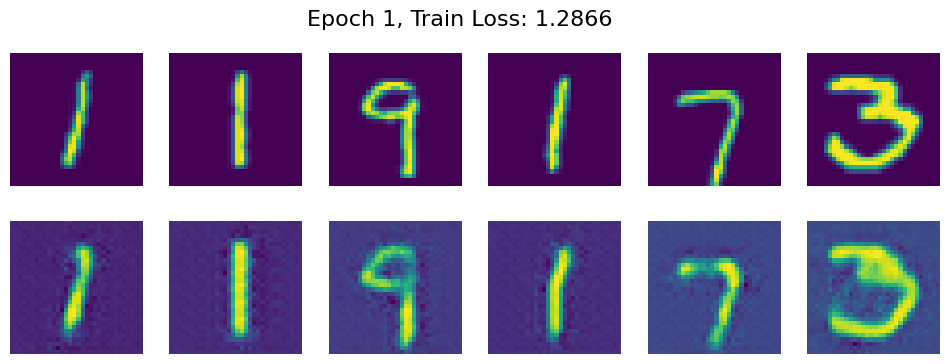

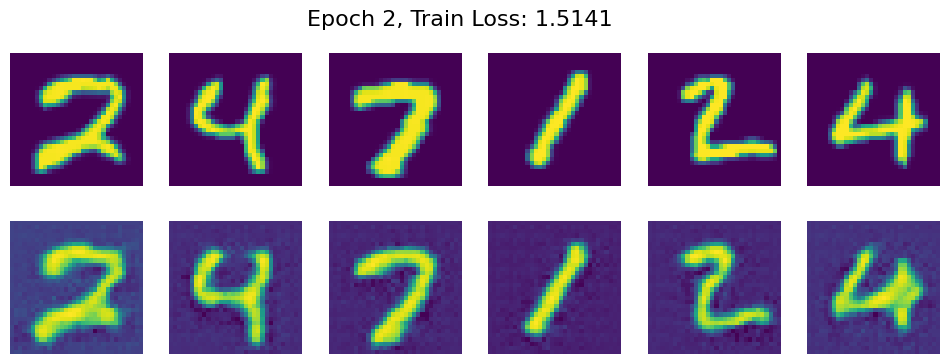

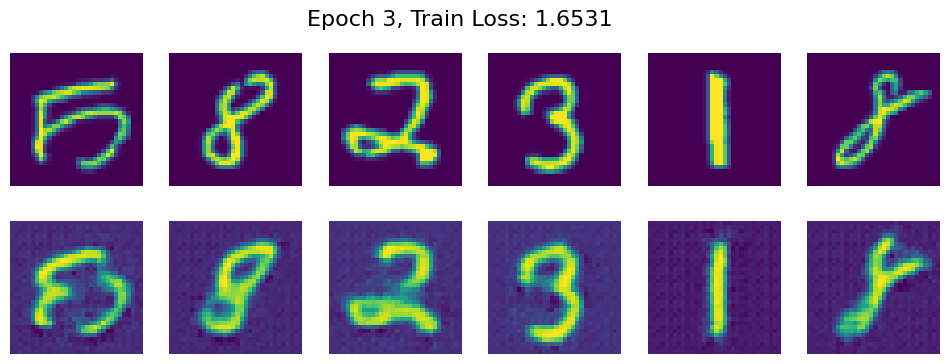

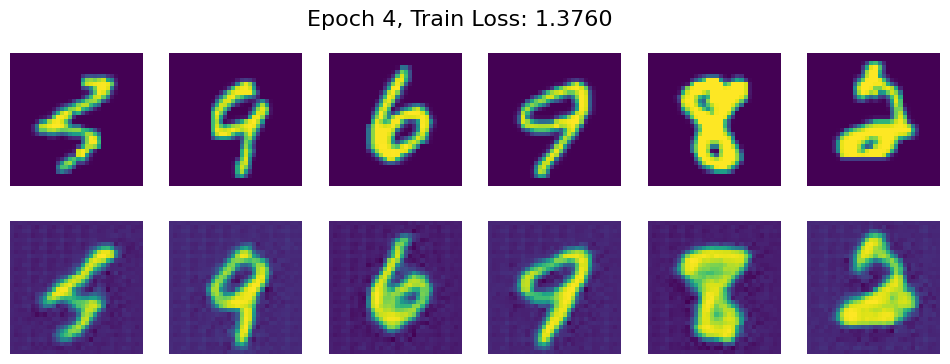

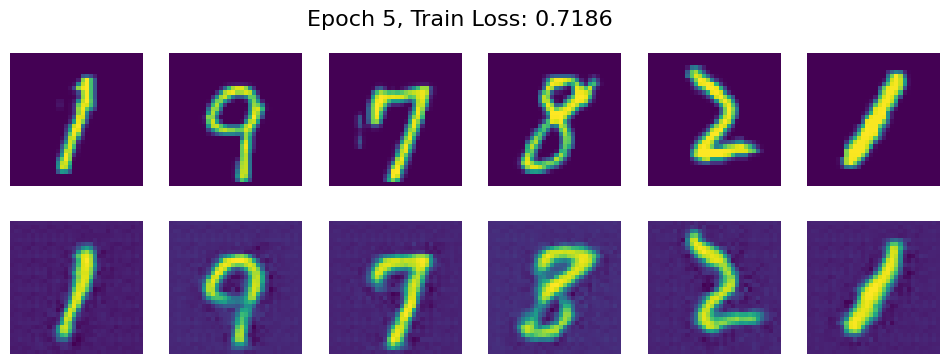

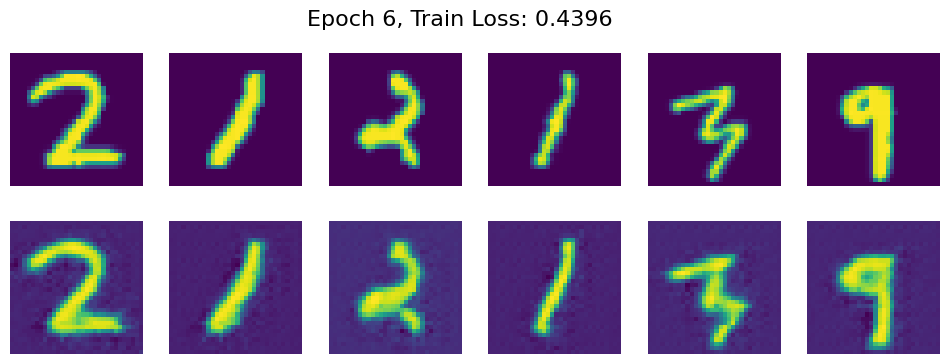

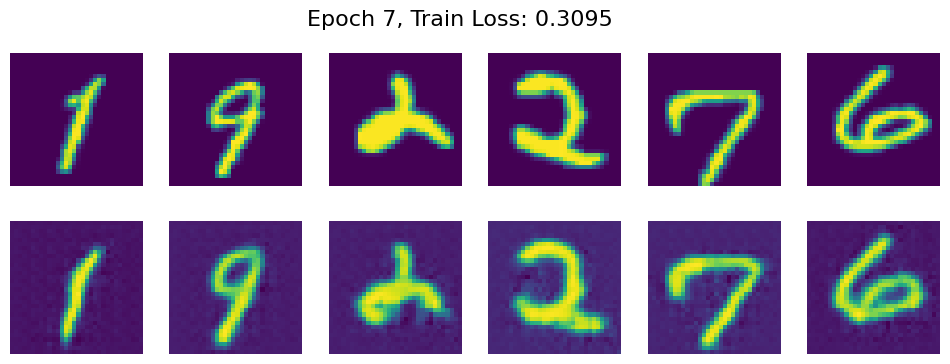

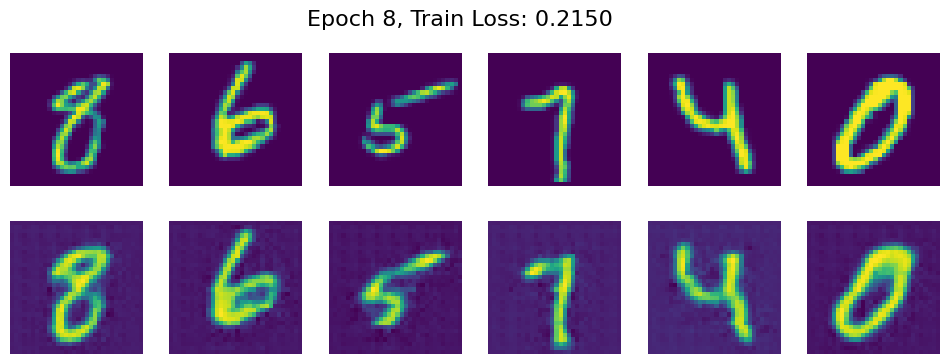

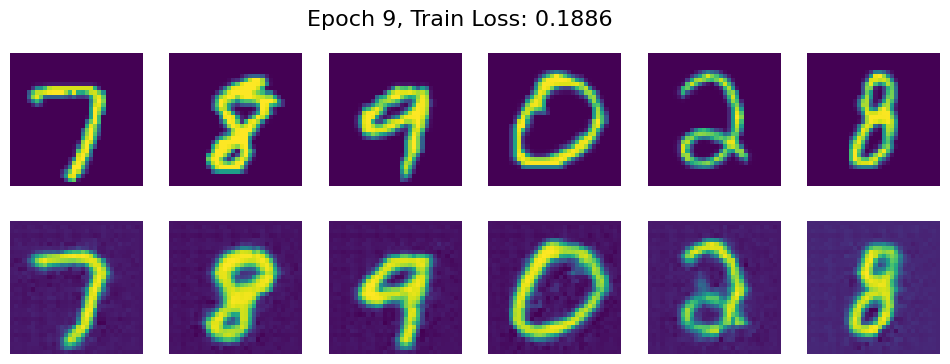

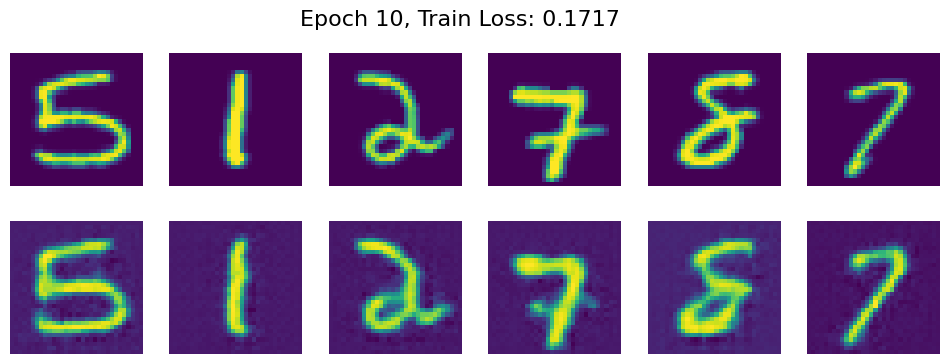

In [21]:
model = VQVAE(in_dim=1, hidden_dim=64, embed_dim=128, n_embedding=3).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_loader, optimizer, n_epochs=10, device=DEVICE)

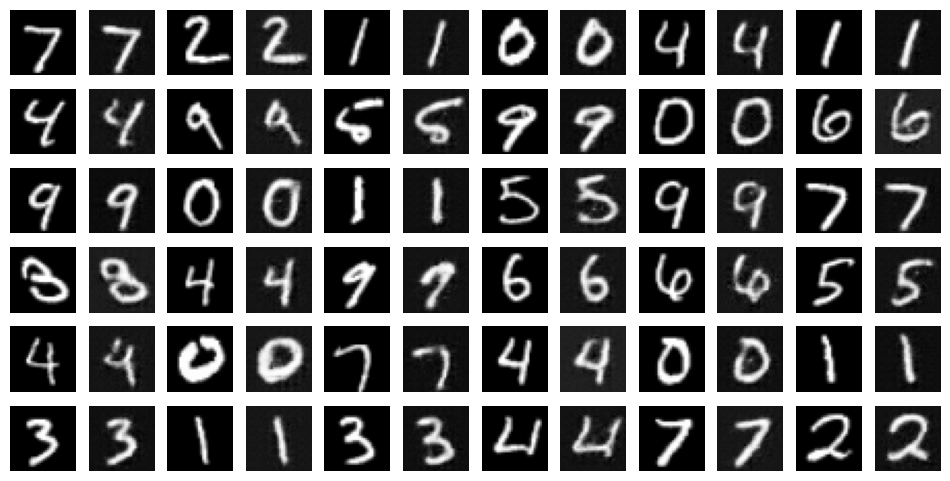

In [22]:
X = next(iter(test_loader))[0][:36].to(DEVICE)
out, _, _ = model(X)
X = X.detach().cpu().numpy()
out = out.detach().cpu().numpy()

fig, ax = plt.subplots(6, 12, figsize=(12, 6))
for i in range(6):
    for j in range(6):
        ax[i, j * 2].imshow(X[i * 6 + j].reshape(32, 32), cmap='gray')
        ax[i, j * 2].axis('off')
        ax[i, j * 2 + 1].imshow(out[i * 6 + j].reshape(32, 32), cmap='gray')
        ax[i, j * 2 + 1].axis('off')

In [24]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Deep unsupervised learning/VAE/vqvae_mnist.pth')

## Train on CIFAR10

In [62]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


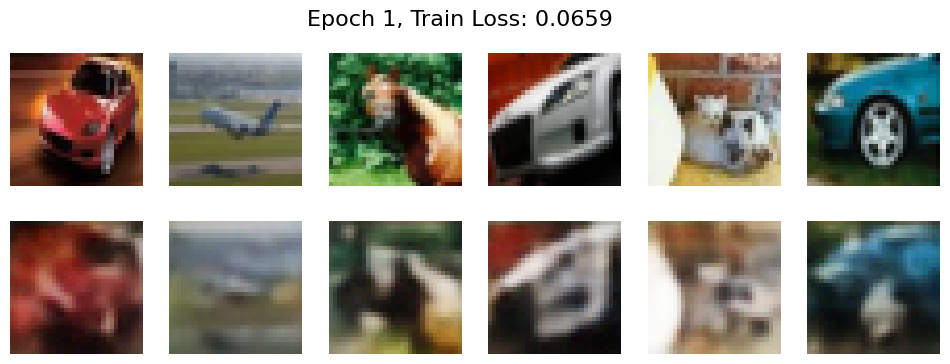

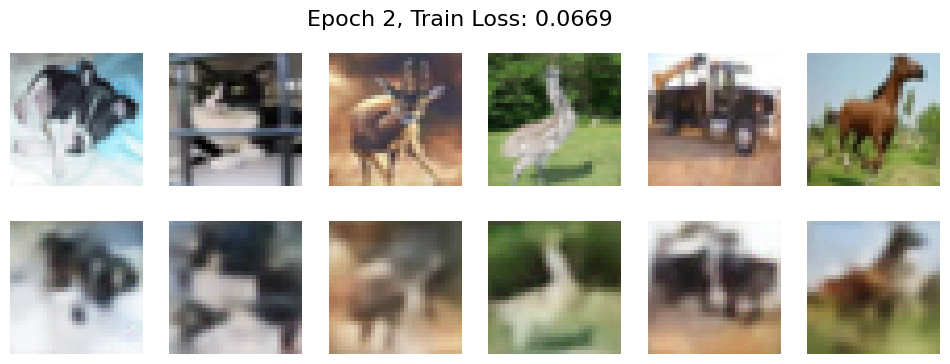

KeyboardInterrupt: 

In [74]:
# model = VQVAE(in_dim=3, hidden_dim=128, embed_dim=256, n_embedding=128).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train(model, train_loader, optimizer, n_epochs=10, device=DEVICE)

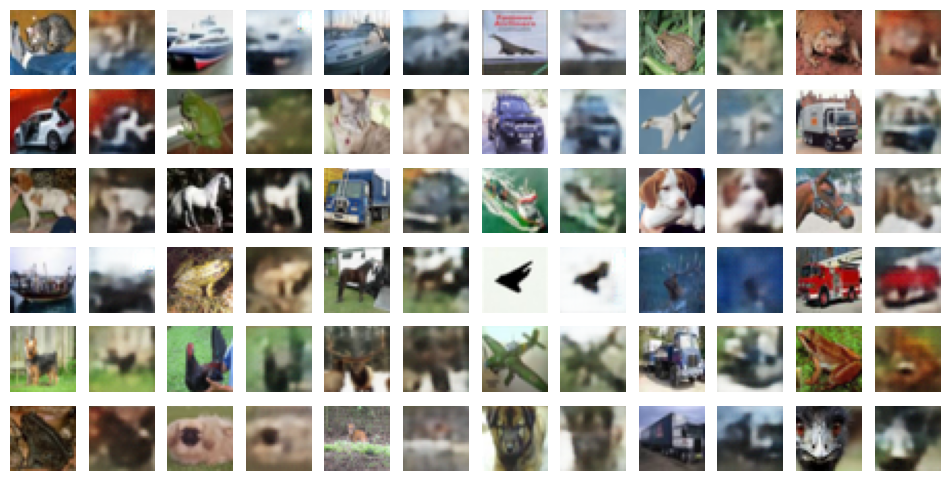

In [72]:
X = next(iter(test_loader))[0][:36].to(DEVICE)
out, _, _ = model(X)
out = out.permute(0, 2, 3, 1).contiguous()
out = torch.clamp(out, 0, 1)
X = X.permute(0, 2, 3, 1).contiguous()
X = X.detach().cpu().numpy()
out = out.detach().cpu().numpy()

fig, ax = plt.subplots(6, 12, figsize=(12, 6))
for i in range(6):
    for j in range(6):
        ax[i, j * 2].imshow(X[i * 6 + j], cmap='gray')
        ax[i, j * 2].axis('off')
        ax[i, j * 2 + 1].imshow(out[i * 6 + j], cmap='gray')
        ax[i, j * 2 + 1].axis('off')

In [73]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Deep unsupervised learning/VAE/vqvae_cifar10.pth')

## PixelCNN implementation

In [10]:
class MaskedConv2d(nn.Module):
    """
    Implementation of masked convolution layer assuming color channels are dependent
    """
    def __init__(self, in_channels, out_channels, kernel_size, mask_type="A", device=DEVICE):
        """
        @param in_channels, out_channels, kernel_size: int
        @param mask_type
            Accepts type "A" or "B" (see figure 1 and 2)
        @ param device: string
        """
        super(MaskedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)
        self.set_mask(kernel_size, mask_type, device)

    def set_mask(self, kernel_size, mask_type, device):
        """
        PixelCNN mask setup
        """
        out_dim, in_dim = self.conv.weight.shape[:2]
        self.mask = torch.ones(self.conv.weight.shape, device=device, requires_grad=False).float()
        one_third_in_dim, one_third_out_dim = in_dim // 3, out_dim // 3

        self.mask[:, :, 1 + kernel_size // 2:, :] = 0.0
        self.mask[:, :, kernel_size // 2, 1 + kernel_size // 2:] = 0.0
        self.mask[:one_third_out_dim, one_third_in_dim:, kernel_size // 2, kernel_size // 2] = 0.0
        self.mask[one_third_out_dim:2*one_third_out_dim, 2*one_third_in_dim:, kernel_size // 2, kernel_size // 2] = 0.0
        self.mask[2*one_third_out_dim:, 3*one_third_in_dim:, kernel_size // 2, kernel_size // 2] = 0.0

        if mask_type == "A":
            self.mask[:one_third_out_dim, :one_third_in_dim, kernel_size // 2, kernel_size // 2] = 0.0
            self.mask[one_third_out_dim:2*one_third_out_dim, one_third_in_dim:2*one_third_in_dim, kernel_size // 2, kernel_size // 2] = 0.0
            self.mask[2*one_third_out_dim:, 2*one_third_in_dim:3*one_third_in_dim, kernel_size // 2, kernel_size // 2] = 0.0

    def forward(self, x):
        """
        @param x: torch.tensor [B, C, H, W]
        """
        self.conv.weight.data *= self.mask
        return self.conv(x)

In [11]:
class ResidualBlock(nn.Module):
    """
    Implementation of residual block with fixed mask type B
    """
    def __init__(self, in_channels):
        """
        @param in_channels: int
        """
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(MaskedConv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, mask_type="B"),
                                 nn.ReLU(),
                                 MaskedConv2d(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=7, mask_type="B"),
                                 nn.ReLU(),
                                 MaskedConv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, mask_type="B"),
                                 nn.ReLU())

    def forward(self, x):
        """
        @param x: torch.tensor [B, C, H, W]
        """
        out = self.net(x)
        return x + out

class PixelCNN(nn.Module):
    """
    Implementation of PixelCNN for both grayscale and colored images
    """
    def __init__(self, in_channels, hidden_channels, n_classes, n_layers, height, width, color_independent=True):
        """
        @param in_channels, hidden_channels: int
        @param n_classes: int
            Number of output classes
        @param n_layers: int
            Number of Residual block layers
        @param height, width: int
        @param color_independent: boolean
            True if assume color channels are independent (default True)
        """
        super(PixelCNN, self).__init__()
        self.net = [MaskedConv2d(in_channels, hidden_channels, kernel_size=7, mask_type="A"),
                    nn.BatchNorm2d(hidden_channels),
                    nn.ReLU()]
        for _ in range(n_layers):
            self.net.extend([ResidualBlock(hidden_channels),
                             nn.BatchNorm2d(hidden_channels),
                             nn.ReLU()])
        self.net.append(MaskedConv2d(hidden_channels, in_channels*n_classes, kernel_size=1, mask_type="B"))
        self.net = nn.ModuleList(self.net)
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.height = height
        self.width = width
        self.color_independent = color_independent

    def forward(self, x):
        """
        @param x: torch.tensor [B, C, H, W]
        """
        x = (x.float() / (self.n_classes - 1) - 0.5) / 0.5
        for layer in self.net:
            x = layer(x)
        if self.color_independent:
            x = x.view(x.shape[0], self.n_classes, self.in_channels, x.shape[2], x.shape[3])
        else:
            x = x.view(x.shape[0], self.in_channels, self.n_classes, x.shape[2], x.shape[3]).permute(0, 2, 1, 3, 4)
        return x

    def sample(self, n_samples, device):
        """
        @param n_samples: int
            Number of samples to geneerate
        @param device: string
        """
        self.eval()
        with torch.no_grad():
            sample = torch.zeros(n_samples, self.in_channels, self.height, self.width).to(device).float()
            for i in range(self.height):
                for j in range(self.width):
                    for c in range(self.in_channels):
                        out = self.forward(sample)
                        logits = out[:, :, c, i, j]
                        prob = nn.Softmax(dim=1)(logits)
                        sample[:, c, i, j] = torch.multinomial(prob, 1).squeeze(-1)
            sample = sample.detach().cpu()
        return sample

## Train the PixelCNN for generation

In [78]:
def plot_samples(pixelcnn, vae, n_samples, device="cpu", title="Generated images"):
    vae.eval()
    samples = pixelcnn.sample(n_samples, DEVICE)
    samples = samples.long().view(-1)
    out = torch.index_select(vae.quantizer.dictionary, dim=0, index=samples.long().to(DEVICE))
    out = out.view(n_samples, 8, 8, vae.embed_dim).permute(0, 3, 1, 2)
    out = vae.decoder(out)
    out = out.permute(0, 2, 3, 1).contiguous()
    out = out.detach().cpu().numpy()
    fig, ax = plt.subplots(1, 6, figsize=(12, 2))
    fig.suptitle(title, fontsize=16)
    for i in range(6):
        ax[i].imshow(out[i], cmap="gray")
        ax[i].axis('off')
    plt.show()

def train_epoch(pixelcnn, vae, train_loader, optimizer, device='cpu'):
    pixelcnn.train()
    vae.eval()
    train_loss = 0.0
    for X, _ in train_loader:
        X = X.to(device)
        out = vae.encoder(X)
        out, _, _, target = vae.quantizer(out) #[B, E, 8, 8], need [B, 8, 8] labels
        target = target.unsqueeze(1)
        out = pixelcnn(target)
        optimizer.zero_grad()
        loss = nn.CrossEntropyLoss()(out, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss

def train(pixelcnn, vae, train_loader, optimizer, n_epochs, device='cpu'):
    for epoch in range(n_epochs):
        train_loss = train_epoch(pixelcnn, vae, train_loader, optimizer, device)
        plot_samples(pixelcnn, vae, 6, title=f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')

In [33]:
model = VQVAE(in_dim=1, hidden_dim=64, embed_dim=128, n_embedding=3).to(DEVICE)
model.load_state_dict(torch.load('/content/drive/MyDrive/Deep unsupervised learning/VAE/vqvae_mnist.pth'))

<All keys matched successfully>

In [34]:
prior = PixelCNN(in_channels=1, hidden_channels=64, n_classes=3, n_layers=3, height=8, width=8).to(DEVICE)
optimizer = optim.Adam(prior.parameters(), lr=1e-3)

In [38]:
optimizer = optim.Adam(prior.parameters(), lr=1e-4)
train(prior, model, train_loader, optimizer, n_epochs=20, device=DEVICE)

In [36]:
torch.save(prior.state_dict(), '/content/drive/MyDrive/Deep unsupervised learning/VAE/vqvae_pixelcnn_mnist.pth')

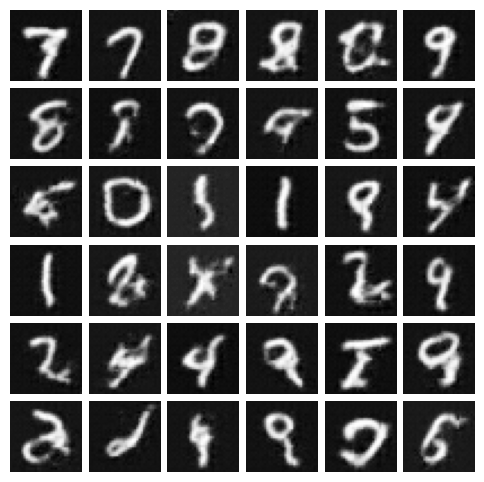

In [38]:
model.eval()
n_samples=36
samples = prior.sample(n_samples, DEVICE)
samples = samples.long().view(-1)
out = torch.index_select(model.quantizer.dictionary, dim=0, index=samples.long().to(DEVICE))
out = out.view(n_samples, 8, 8, 128).permute(0, 3, 1, 2)
out = model.decoder(out)
out = out.permute(0, 2, 3, 1).contiguous()
out = out.detach().cpu().numpy()

grid_size = int(np.sqrt(n_samples))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
axes = axes.flatten()
for i in range(n_samples):
    axes[i].imshow(out[i], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Train prior on Cifar10

In [75]:
model = VQVAE(in_dim=3, hidden_dim=128, embed_dim=256, n_embedding=128).to(DEVICE)
model.load_state_dict(torch.load('/content/drive/MyDrive/Deep unsupervised learning/VAE/vqvae_cifar10.pth'))

<All keys matched successfully>

In [76]:
prior = PixelCNN(in_channels=1, hidden_channels=64, n_classes=128, n_layers=3, height=8, width=8).to(DEVICE)

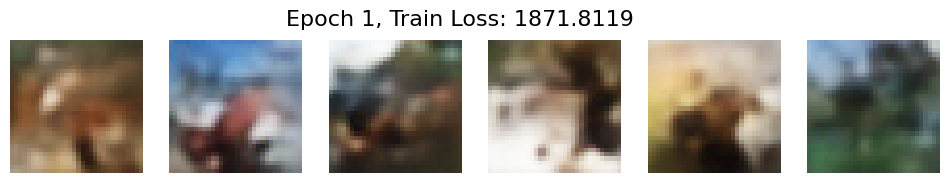

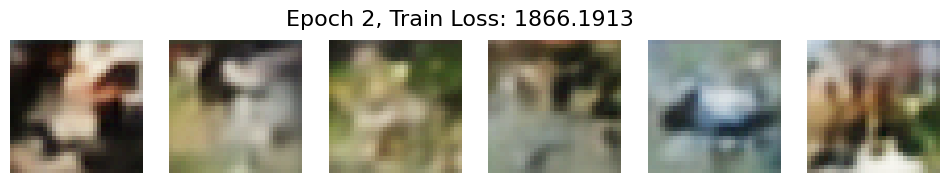

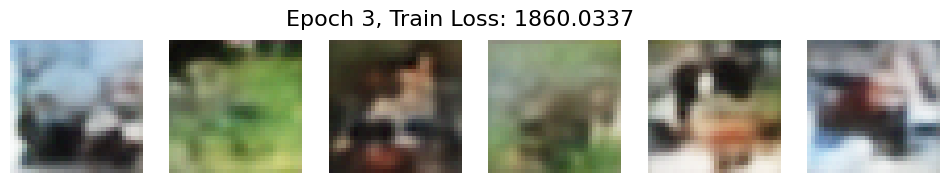

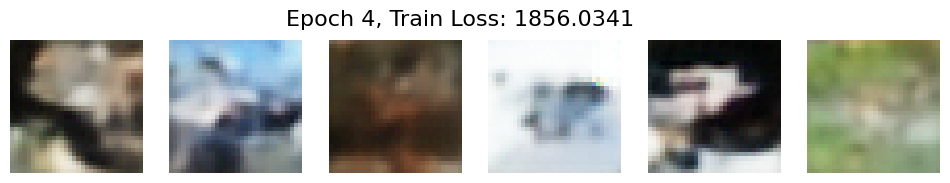

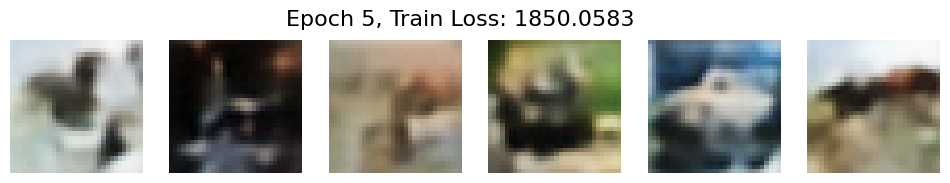

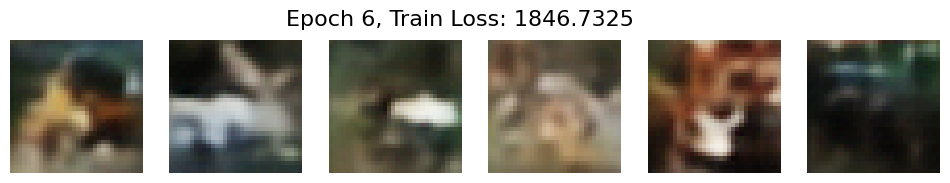

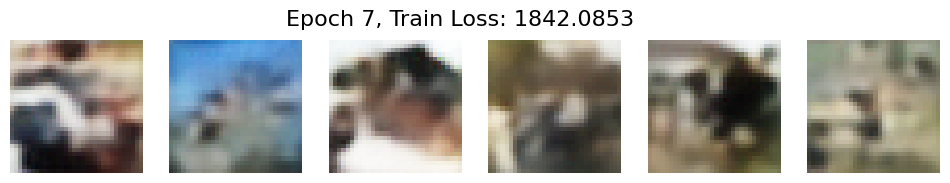

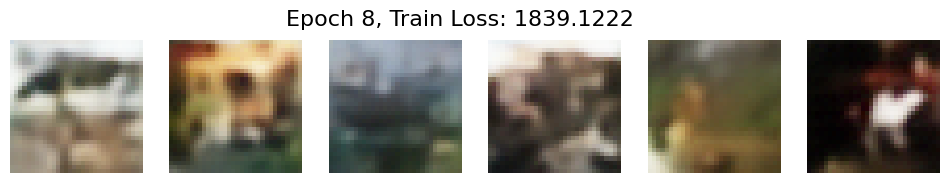

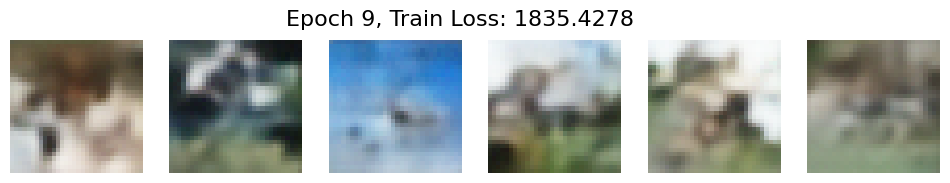

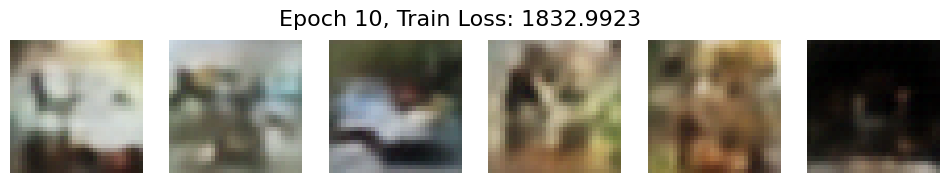

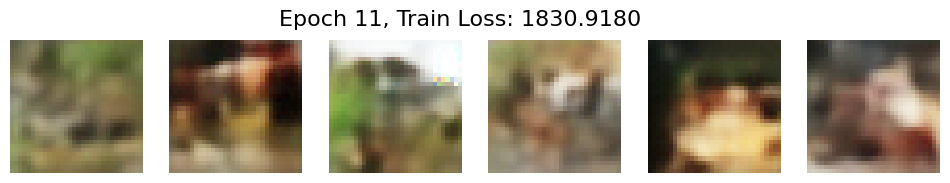

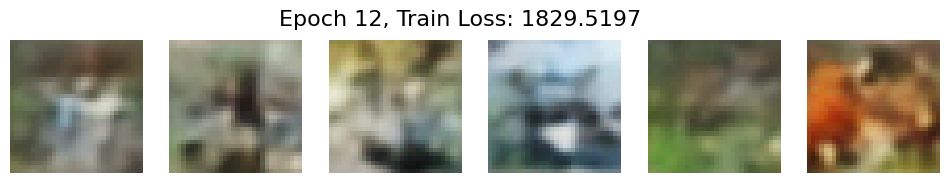

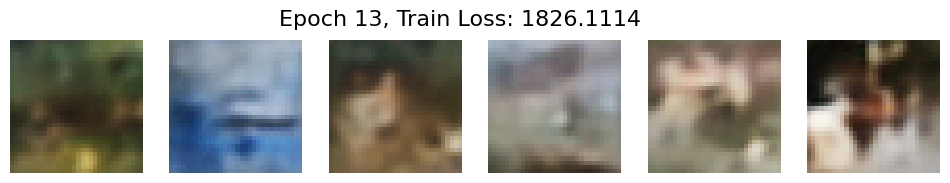

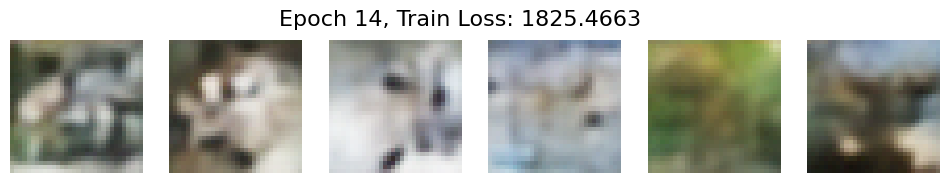

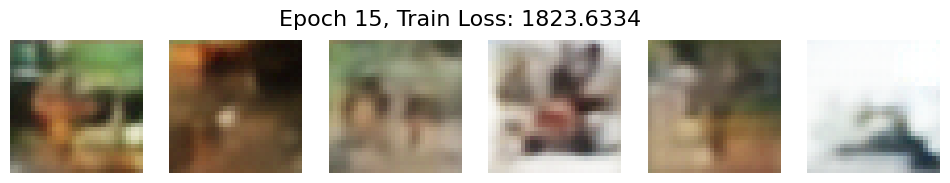

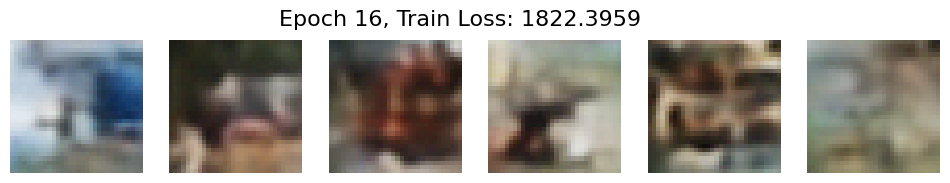

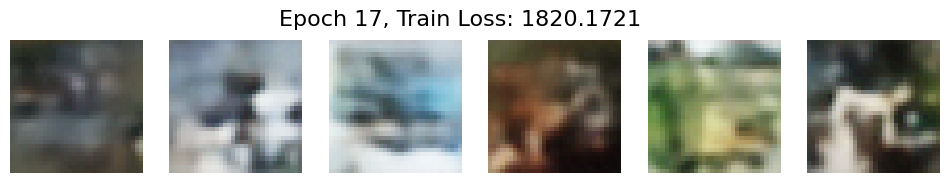

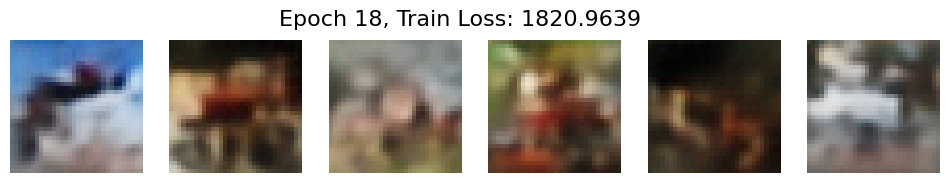

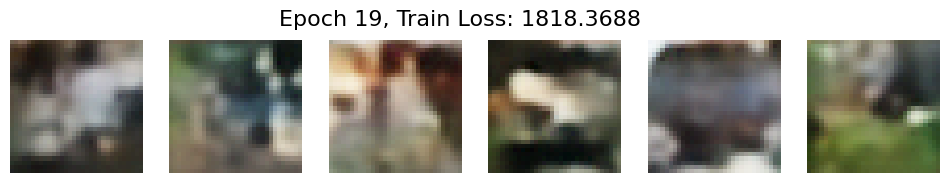

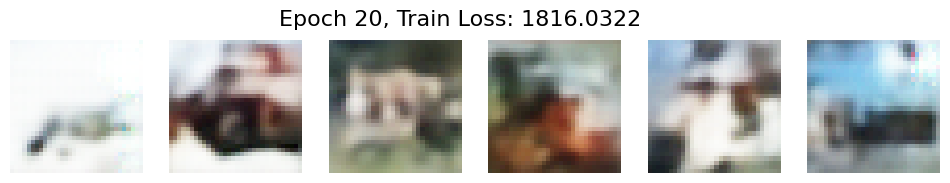

In [82]:
optimizer = optim.Adam(prior.parameters(), lr=1e-3)
train(prior, model, train_loader, optimizer, n_epochs=20, device=DEVICE)

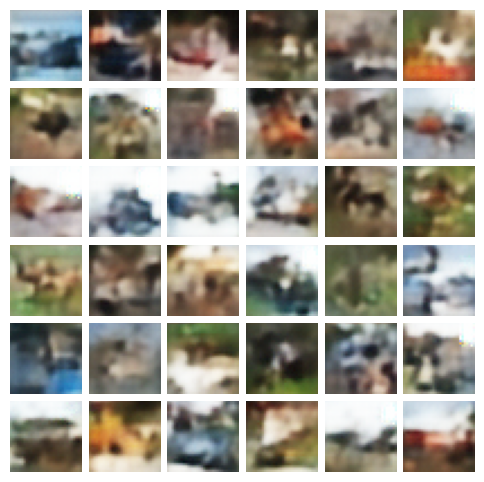

In [83]:
model.eval()
n_samples=36
samples = prior.sample(n_samples, DEVICE)
samples = samples.long().view(-1)
out = torch.index_select(model.quantizer.dictionary, dim=0, index=samples.long().to(DEVICE))
out = out.view(n_samples, 8, 8, model.embed_dim).permute(0, 3, 1, 2)
out = model.decoder(out)
out = torch.clamp(out, 0, 1)
out = out.permute(0, 2, 3, 1).contiguous()
out = out.detach().cpu().numpy()

grid_size = int(np.sqrt(n_samples))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
axes = axes.flatten()
for i in range(n_samples):
    axes[i].imshow(out[i], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [84]:
torch.save(prior.state_dict(), '/content/drive/MyDrive/Deep unsupervised learning/VAE/vqvae_pixelcnn_cifar10.pth')